# Predict the NBA 2020-21 MVP Award Ladder Rankings and Winner

## Load datasets, data preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import matplotlib.pyplot as plt

# load historical NBA MVP award voting and player stats data from 1980-1981 to 2019-2020 NBA season.
df_historical = pd.read_csv("historical.csv")
df_historical = df_historical.drop(df_historical.columns[0], axis=1)
print("Historical dataset preview")
print(df_historical.head(5))

# load current NBA MVP ladder and player stats (updated again week 4/16/21) from current 2020-2021 NBA season. 
df_current = pd.read_csv("current.csv")
df_current = df_current.drop(df_current.columns[0], axis=1)
df_current = df_current.reindex(df_historical.columns, axis=1) # match column headers
df_current = df_current.dropna(axis=1, how="all") 

print("\n\nCurrent dataset preview")
print(df_current.head(5))

# check missing values
print("")
print(df_historical.isnull().sum())
print("There are no missing values in the historical dataset")

print("\n")
print(df_current.isnull().sum())
print("There are no missing values in the current dataset")

Historical dataset preview
                player   season   per  ts_pct  usg_pct  bpm  vorp   win_pct  \
0        Julius Erving  1980-81  25.1   0.572     28.4  7.5   6.9  0.756098   
1           Larry Bird  1980-81  19.9   0.528     24.3  4.3   5.2  0.756098   
2  Kareem Abdul-Jabbar  1980-81  25.5   0.616     26.3  6.1   6.1  0.658537   
3         Moses Malone  1980-81  25.1   0.585     27.6  3.3   4.3  0.487805   
4        George Gervin  1980-81  22.9   0.555     32.3  2.9   3.5  0.634146   

   votes_first  points_won  ...  pts_per_g  trb_per_g  ast_per_g  stl_per_g  \
0         28.0       454.0  ...       24.6        8.0        4.4        2.1   
1         20.0       423.0  ...       21.2       10.9        5.5        2.0   
2          8.0       286.0  ...       26.2       10.3        3.4        0.7   
3          8.0       180.0  ...       27.8       14.8        1.8        1.0   
4          1.0        83.0  ...       27.1        5.1        3.2        1.1   

   blk_per_g  fg_pct  f

 ## Visualize correlation between features

<AxesSubplot:>

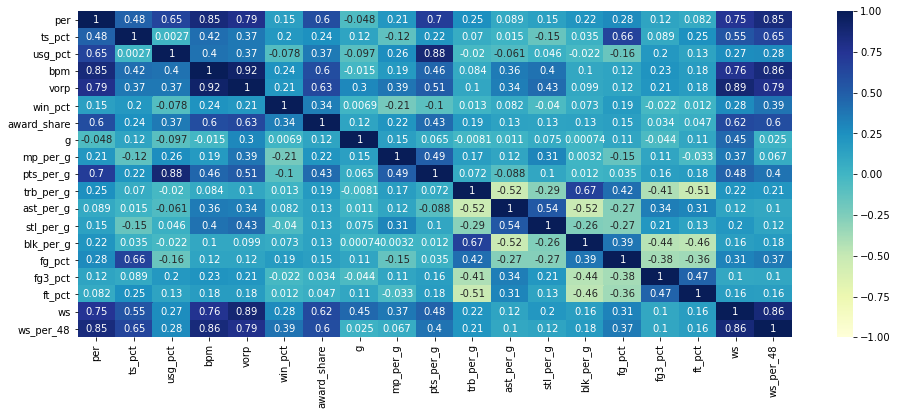

In [2]:
import seaborn as sns

# correlation matrix
stats = df_historical.drop(["player", "season", "votes_first", "points_won", "points_max"], axis=1)

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(stats.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu", ax=ax)

## Visualize award share

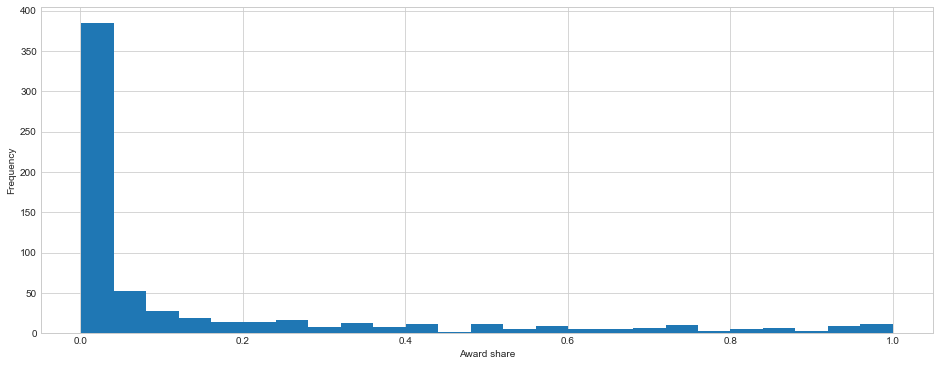

In [3]:
# histogram of target y: award share
plt.style.use("seaborn-whitegrid")

plt.figure(figsize=(16, 6))
plt.hist(df_historical["award_share"], bins = 25)
plt.xlabel("Award share")
plt.ylabel("Frequency")

plt.show()

## Split the preprocessed dataset (80-20)



In [4]:
# drop unneeded features
X = df_historical.drop(["player", "season", "votes_first", "points_won", "points_max", "award_share"], axis=1)
y = df_historical["award_share"].values

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

# scaling
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

X_train shape: (528, 18)
X_test shape: (133, 18)


In [5]:
# function to calculate and print performance of a model

def evaluate(pred, gt):
    mae = mean_absolute_error(gt, pred)
    mse = mean_squared_error(gt, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(gt, pred)
    
    print("MAE: {}".format(mae))
    print("MSE: {}".format(mse))
    print("RMSE: {}".format(rmse))
    print("R2: {}".format(r2)) # note: higher r2, better fit

## Model 1: linear regression

In [6]:
# train linear regression model
lr = LinearRegression()

lr.fit(X_train, y_train)
print("bias: ", lr.intercept_)
print("coefficients: ", lr.coef_)

y_train_pred = lr.predict(X_train)

# evaluate using training set
print("\nLinear regression, prediction for our training set")
evaluate(y_train_pred, y_train)

# evaluate using test set
y_test_pred = lr.predict(X_test)
print("\nLinear regression, prediction for our testing set")
evaluate(y_test_pred, y_test)

bias:  0.16291666666666643
coefficients:  [-0.112176   -0.07616078  0.03882501  0.14452517 -0.06641536  0.04019634
 -0.07913904 -0.06637141  0.08107394  0.04617876  0.06281076 -0.02918888
  0.00577236  0.04364682  0.00063245  0.00998128  0.31445493 -0.12228358]

Linear regression, prediction for our training set
MAE: 0.13018307653115832
MSE: 0.03002270050972131
RMSE: 0.17327059909205977
R2: 0.5555224085387089

Linear regression, prediction for our testing set
MAE: 0.14734349436660152
MSE: 0.035946152877397164
RMSE: 0.18959470688127653
R2: 0.43877091994161055


##  Model 2: ridge regression

In [7]:
# train ridge regression model
strengths = [.001, .01, .05, .1, 1.0, 10.0]
best_mse = 0
best_strength = strengths[0]

# find best hyper param 
for strength in strengths:
    rr = Ridge(alpha=strength)
    rr.fit(X_train, y_train)
    
    y_train_pred = rr.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    
    if(mse < best_mse):
        best_mse = mse
        best_strength = strength


# retrain using best hyper param
rr = Ridge(alpha=best_strength)
rr.fit(X_train, y_train)
print("bias: ", lr.intercept_)
print("coefficients: ", lr.coef_)

y_train_pred = rr.predict(X_train)

print("\nRidge regression (lamda={}), prediction for our training set".format(best_strength))
evaluate(y_train_pred, y_train)

y_test_pred = rr.predict(X_test)
print("\nRidge regression (lamda={}), prediction for our testing set".format(best_strength))
evaluate(y_test_pred, y_test)

bias:  0.16291666666666643
coefficients:  [-0.112176   -0.07616078  0.03882501  0.14452517 -0.06641536  0.04019634
 -0.07913904 -0.06637141  0.08107394  0.04617876  0.06281076 -0.02918888
  0.00577236  0.04364682  0.00063245  0.00998128  0.31445493 -0.12228358]

Ridge regression (lamda=0.001), prediction for our training set
MAE: 0.13018380640812274
MSE: 0.030022700694338638
RMSE: 0.1732705996248026
R2: 0.5555224058055015

Ridge regression (lamda=0.001), prediction for our testing set
MAE: 0.14734388737626725
MSE: 0.035945977091554206
RMSE: 0.18959424329750682
R2: 0.4387736644947555


## Model 3: lasso regression

In [8]:
# train lasso regression model (similar to previous cell)
strengths = [.001, .005, .01, .05, .1, 1.0, 10.0]
best_mse = 0
best_strength = strengths[0]

# find best hyper param 
for strength in strengths:
    lasso_reg = Lasso(alpha=strength)
    rr.fit(X_train, y_train)
    
    y_train_pred = rr.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    
    if(mse < best_mse):
        best_mse = mse
        best_strength = strength


# retrain using best hyper param
lasso = Lasso(alpha=best_strength)
lasso.fit(X_train, y_train)
print("bias: ", lasso.intercept_)
print("coefficients: ", lasso.coef_)

y_train_pred = lasso.predict(X_train)

print("\nLasso regression (lamda={}), prediction for our training set".format(best_strength))
evaluate(y_train_pred, y_train)

y_test_pred = lasso.predict(X_test)
print("\nLasso regression (lamda={}), prediction for our testing set".format(best_strength))
evaluate(y_test_pred, y_test)

bias:  0.16291666666666654
coefficients:  [-0.05607901 -0.06500206  0.01730684  0.04213056  0.03834506  0.04166311
 -0.03643803 -0.03547602  0.07321365  0.03614357  0.04995177 -0.0278747
  0.          0.02767984 -0.          0.00210008  0.13462551 -0.        ]

Lasso regression (lamda=0.001), prediction for our training set
MAE: 0.1322080547114767
MSE: 0.030426041256266616
RMSE: 0.17443062017967664
R2: 0.5495510628396567

Lasso regression (lamda=0.001), prediction for our testing set
MAE: 0.1477834130021575
MSE: 0.035661671035947945
RMSE: 0.18884297984290532
R2: 0.4432125491394393


## Model 4: support vector regression

In [9]:
from sklearn.svm import SVR

# train support vector regression model
#svr = SVR(kernel="rbf", C=100, gamma=0.0001, epsilon=.1)
# svr = SVR()
svr = SVR(kernel="rbf", C=100, gamma=0.001, epsilon=.1)

svr.fit(X_train, y_train)
y_train_pred = svr.predict(X_train)

print("\nSupport vector regression, prediction for our training set")
evaluate(y_train_pred, y_train)

y_test_pred = svr.predict(X_test)
print("\nSVR, prediction for our testing set")
evaluate(y_test_pred, y_test)


Support vector regression, prediction for our training set
MAE: 0.09755806831044614
MSE: 0.0200529666139874
RMSE: 0.14160849767576592
R2: 0.7031214997014424

SVR, prediction for our testing set
MAE: 0.11284715316226215
MSE: 0.02494065779758087
RMSE: 0.15792611499552844
R2: 0.6106002642472221


## Model 5: k nearest neighbors regression

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# train train knn regression model
# nn = list(range(2, 10))

# best_mse = 0
# best_n = nn[0]; 

# # find best num of neighbors 
# for n in nn:
#     knn = KNeighborsRegressor(n_neighbors=n, weights="uniform")
#     knn.fit(X_train, y_train)
    
#     y_train_pred = knn.predict(X_train)
#     mse = mean_squared_error(y_train, y_train_pred)
    
#     if(mse < best_mse):
#         best_mse = mse
#         best_n = n


nn = {"n_neighbors" : [2, 3, 4, 5, 6, 7, 8, 9]}
knn = KNeighborsRegressor()
grid = GridSearchCV(knn, nn, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_)

knn = KNeighborsRegressor(**grid.best_params_)
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)

print("\nKNN regression ({}), prediction for our training set".format(grid.best_params_))
evaluate(y_train_pred, y_train)

y_test_pred = knn.predict(X_test)
print("\nKNN regression ({}), prediction for our testing set".format(grid.best_params_))
evaluate(y_test_pred, y_test)

{'n_neighbors': 7}

KNN regression ({'n_neighbors': 7}), prediction for our training set
MAE: 0.09164475108225109
MSE: 0.021286406578540508
RMSE: 0.14589861746617241
R2: 0.6848607698087685

KNN regression ({'n_neighbors': 7}), prediction for our testing set
MAE: 0.11824167561761545
MSE: 0.03846093279116158
RMSE: 0.19611459096956957
R2: 0.3995075355576093


## Predict award share 2020-21 NBA season

In [11]:
# store player names, drop unneeded features
names = df_current["player"]
X_current = df_current.drop(["player", "season"], axis=1)

# scaling
normalizer = StandardScaler()
X_current = normalizer.fit_transform(X_current)

# predict based on provided trained model
def prediction(model):
    ladder = model.predict(X_current)
    ladder = ladder.tolist()
    table = pd.DataFrame()
    
    total = 0
    
    for i in range(0, len(ladder)):
        total = total + ladder[i]
    
#     total = sum(ladder)
    
    for name, share in zip(names, ladder):
        if(share < 0):
            share = 0.00
        percentage = share/total * 100
        #print("{}: {:.2f} {:.2f}%".format(name, share, percentage))
        row = [name, share, percentage]
        temp = pd.DataFrame([row])
        table = table.append(temp)
        
        
    table.columns= ["Name", "Share", "Percentage"]
    table = table.sort_values(by = "Share", ascending = False)
    table =  table.reset_index(drop=True)
    return table;

print("Linear regression ladder prediction")
lr_df = prediction(lr)
print(lr_df.to_string(index=False))

print("\nRidge regression ladder prediction")
rr_df = prediction(rr)
print(rr_df.to_string(index=False))

print("\nLasso regression ladder prediction")
lasso_df = prediction(lasso)
print(lasso_df.to_string(index=False))

print("\nSVR ladder prediction")
svr_df = prediction(svr)
print(svr_df.to_string(index=False))

print("\nKNN ladder prediction")
knn_df = prediction(knn)
print(knn_df.to_string(index=False))

Linear regression ladder prediction
                 Name    Share  Percentage
         Nikola Jokic 0.605525   37.167767
Giannis Antetokounmpo 0.273180   16.768106
         LeBron James 0.220533   13.536561
          Luka Doncic 0.207107   12.712467
         James Harden 0.091777    5.633355
          Joel Embiid 0.086936    5.336214
        Kawhi Leonard 0.060963    3.741975
          Rudy Gobert 0.046189    2.835120
       Damian Lillard 0.035167    2.158563
        Stephen Curry 0.001790    0.109872

Ridge regression ladder prediction
                 Name    Share  Percentage
         Nikola Jokic 0.605485   37.165318
Giannis Antetokounmpo 0.273164   16.767099
         LeBron James 0.220497   13.534360
          Luka Doncic 0.207109   12.712567
         James Harden 0.091787    5.634013
          Joel Embiid 0.086972    5.338438
        Kawhi Leonard 0.060982    3.743120
          Rudy Gobert 0.046188    2.835092
       Damian Lillard 0.035191    2.160061
        Stephen Curry 0.0

## Visualize ladder/rankings for each model

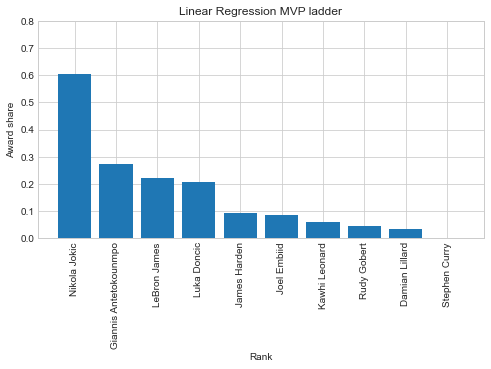

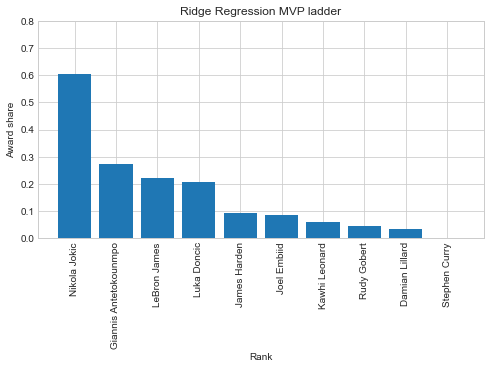

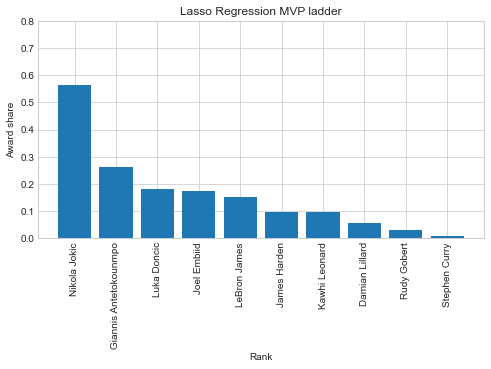

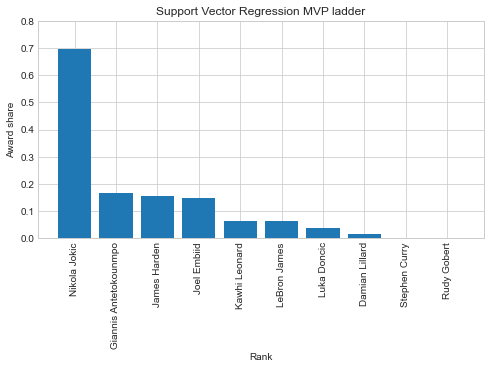

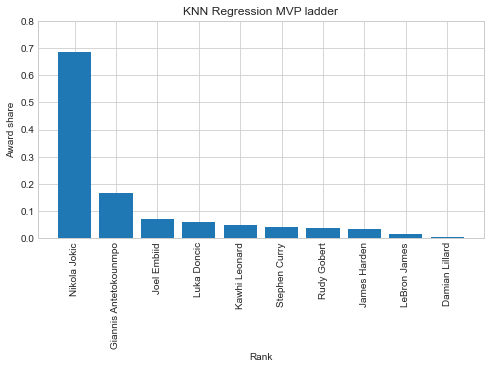

In [12]:
def plot_ladder(df, title):
    
    labels = ["Name", "Share", "Percentage"]
    players = df["Name"].values
    share = df["Share"].values

    plt.style.use("seaborn-whitegrid")
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.bar(players, share)

    ax.set_title("{} MVP ladder".format(title))
    ax.set_xlabel("Rank")
    ax.set_ylabel("Award share")
    ax.set_ylim([0.0, 0.8])
    plt.xticks(rotation="vertical")

    plt.show()


plot_ladder(lr_df, "Linear Regression")
plot_ladder(rr_df, "Ridge Regression")
plot_ladder(lasso_df, "Lasso Regression")
plot_ladder(svr_df, "Support Vector Regression")
plot_ladder(knn_df, "KNN Regression")

# Averages of award share for each player/ average ranking

Averaged award share for each player from linear, ridge, lasso, support vector and knn regression models.
                 Name  Award Share
         Nikola Jokic     0.631459
Giannis Antetokounmpo     0.228195
          Luka Doncic     0.138822
         LeBron James     0.134634
          Joel Embiid     0.113763
         James Harden     0.094488
        Kawhi Leonard     0.066327
          Rudy Gobert     0.032334
       Damian Lillard     0.029693
        Stephen Curry     0.010336




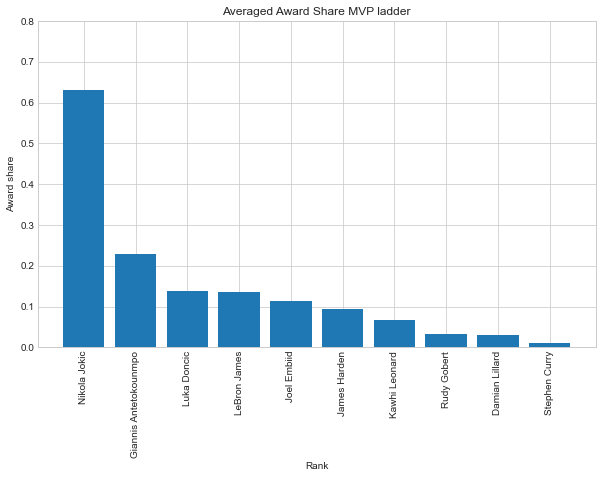

NBA.com most recent MVP ladder: 
Nikola Jokic, Joel Embiid, Luka Doncic, Giannis Antetokounmpo, Damian Lillard, Kawhi Leonard, James Harden, LeBron James, Stephen Curry, Rudy Gobert


In [25]:
# get average award share for each player
players = df_current["player"].values
averages = {key: None for key in players}
dfs = [lr_df, rr_df, lasso_df, svr_df, knn_df]

for player in players:
    
    sum = 0.00
    
    for df in dfs:
        share = df.loc[df.Name == player, "Share"].values
        sum += share
    
    mean = sum[0]/len(dfs)
    averages[player] = mean


# sort dictionary by share descending 
averages = sorted(averages.items(), key=lambda x: x[1], reverse=True)

players = []
shares = []

# separate, lists to plot
for player in averages:
    players.append(player[0])
    shares.append(player[1])

print("Averaged award share for each player from linear, ridge, lasso, support vector and knn regression models.")
averages_df = pd.DataFrame.from_dict(averages)
averages_df.columns = ["Name", "Award Share"]
print(averages_df.to_string(index=False))
print("\n")

# bar plot average shares/ladder
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(players, shares)

ax.set_title("Averaged Award Share MVP ladder")
ax.set_xlabel("Rank")
ax.set_ylabel("Award share")
ax.set_ylim([0.0, 0.8])
plt.xticks(rotation="vertical")

plt.show()

print("NBA.com most recent MVP ladder: ")
print("Nikola Jokic, Joel Embiid, Luka Doncic, Giannis Antetokounmpo, Damian Lillard, Kawhi Leonard, James Harden, LeBron James, Stephen Curry, Rudy Gobert")